# Tutorial: Building your own forward problem

One goal of jInv is to be easy to extend and simplify implemenating of and experimenting with new forward problems. Following some simple guidelines you can benefit from the different built-in options for regularization, misfit, optimization, visualization, PDE solvers, and even run your inversion in parallel. 

This tutorial gives a step by step introduction on how to implement and test your forward problem for jInv. Here, we develop a simple code for Full Waveform Inversion (FWI) that is parameter estimation for the Helmholtz equation.

### Outline and Goal

The major steps consists of extending methods in `jInv.ForwardShare` (therefore, those must be imported first!). 

1. Create a type `MyFWIparam <: ForwardProbType` that contains a description of your forward problem
1. Write a method `getData` that solves the forard problem and simulates the data
1. Write methods `getSensMatVec` and `getSensTMatVec` that compute matrix vector products with the sensitivity matrix and its transpose.
1. For full functionality, write methods `getNumberOfData` and `getSensMatSize`. 
1. Test your code!


In [1]:
using jInv.ForwardShare
using jInv.Mesh
using jInvVis
using jInv.Utils
using PyPlot
using MAT
using Test

## 0) Load some test data

We have prepared some test data in the file `ex2DFWI.mat`. 

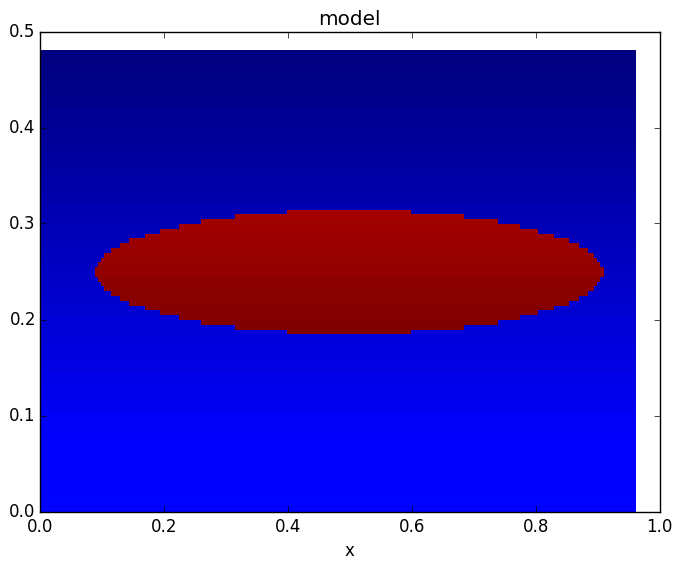

PyObject <matplotlib.text.Text object at 0x324e489d0>

In [2]:
matfile = matread("ex2DFWI.mat")
domain = matfile["domain"]
n      = matfile["n"]
k0     = matfile["k0"]
Sources = matfile["Sources"]
Receivers = matfile["Receivers"]
gamma  = vec(matfile["gamma"])
Mfwd   = getRegularMesh(domain,n);


omega = 5*pi*[1.5;6.0]

viewImage2D(k0,Mfwd)
title("model")
xlabel("x")


##1)  Define `MyFWIparam` and PDE Operator

First, we define a new type that contains all data needed to run our simulations and may also contain space for intermediate results. 

One thing to consider is to make your type a sub-type of the abstract `ForwardProbType`. This way you make sure to benefit from the methods implemented in `jInv.ForwardShare`.

Also note that one purpose of creating your own type is to use multiple dispatch to help Julia find the right method of `getData`. 

In [10]:
"""
write a docstring to tell people how to use your type
"""
type MyFWIparam <: ForwardProbType
    omega     # frequencies
    gamma     # attenuation
    Sources   # Sources
    Receivers # Receivers
    Mesh      # Mesh
    U         # Fields
    LU        # LU factorization
end

function getHelmholtzOperator(m,gamma,omega::Number,Mesh::RegularMesh)
    Lap   = getNodalLaplacianMatrix(Mesh)
    An2cc = getNodalAverageMatrix(Mesh)
    M     = sdiag(An2cc'*(m.*(1-1im*gamma)))
    
    # Get the Helmholtz operator (note the sign)
    H = Lap - omega^2 * M
    return H
end


pFor = MyFWIparam(omega,gamma,Sources,Receivers,Mfwd,[],[]);


## 2) Solving the Forward Problem:  `getData`

Next, we code a method that, given a current model $m$, frequencies $\omega_1,\ldots,\omega_n$, sources $q_1, \ldots q_m$, receivers $P$, computes the data 
$$ 
D_i =  P^\top u(m,\omega,q_i),
$$
where the fields $u(m,\omega,q_i)$ satisfy
$$
-\Delta u - \omega^{2} m\, (1-\gamma i)\, u = -q_i
$$ 

In order to be compatible with `jInv` your methos must look like this

```
function  getData(m,pFor::MyFWIparam)
.
.
.
return D,pFor # data, pFor (containing factorizations, fields)
end

```

In [4]:
import jInv.ForwardShare.getData

function  getData(m,pFor::MyFWIparam)
Mesh  = pFor.Mesh
omega = pFor.omega
gamma = pFor.gamma
Q     = pFor.Sources
P     = pFor.Receivers

nrec = size(P,2) 
nsrc = size(Q,2)
nfreq = length(omega)

U  = zeros(Complex128,prod(Mesh.n+1),nsrc,nfreq)
D  = zeros(nrec,nsrc,nfreq)

LU = Array{Any}(nfreq)
for i=1:length(omega)
    H = getHelmholtzOperator(m,gamma,omega[i],Mesh)
    
    LU[i] = lufact(H)
    for k=1:nsrc
        U[:,k,i] = LU[i]\full(Q[:,k])
        D[:,k,i] = real(P'*U[:,k,i])
    end
end
pFor.LU = LU
pFor.U  = U
return D,pFor
end



getData (generic function with 12 methods)

## Test getData

To make sure `getData` runs, lets call it with the provided reference model and visualize the fields for different frequencies.

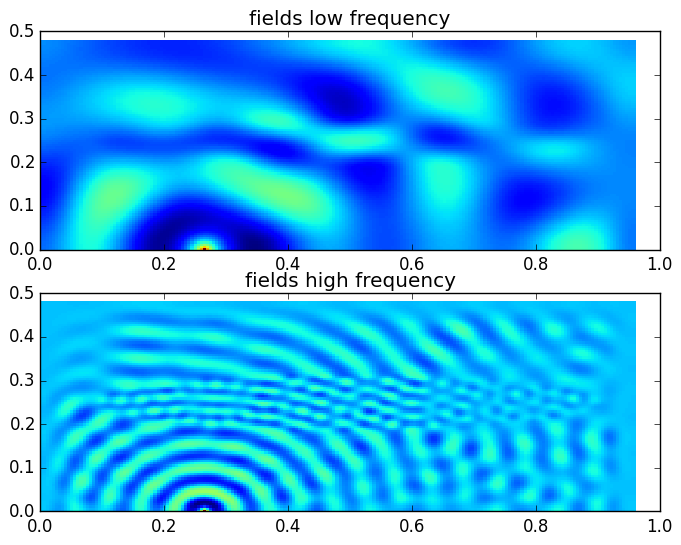

In [5]:
# a test call
dobs,pFor = getData(vec(k0),pFor);

M2d = getRegularMesh(domain,n+1)
subplot(2,1,1)
viewImage2D(real(pFor.U[:,20,1]),M2d)
title("fields low frequency")
subplot(2,1,2)
viewImage2D(real(pFor.U[:,20,2]),M2d)
title("fields high frequency");

## 3) `getSensMatVec` and `getSensTMatVec`

Next we implement methods that computes matrix vector products with the sensitivity matrix and its transpose. 

Recall, that the sensitivity matrix is defined as

$$
J = P^\top \ \nabla_m u(m)
$$

where

$$ 
\nabla_m u(m) = \omega^2 H^{-1} \mathrm{diag}(u(m)) A_v \mathrm{diag}(1-\gamma i)
$$

In order to be compatible with `jInv` the solvers just complete the below functions your methods should look like this

```
function getSensMatVec(v::Vector,m::Vector,pFor::MyFWIparam)
    # -----------------------------------------
    #         !!! your code here !!!
    #  
    # -----------------------------------------
    return Jv
end

function getSensTMatVec(v::Vector,m::Vector,pFor::MyFWIparam)
    # -----------------------------------------
    #         !!! your code here !!!
    #  
    # -----------------------------------------
    return JTv
end
```



In [6]:
import jInv.ForwardShare.getSensMatVec
function getSensMatVec(v::Vector{Float64},m::Vector{Float64},pFor::MyFWIparam)

Mesh  = pFor.Mesh
omega = pFor.omega
gamma = pFor.gamma
Q     = pFor.Sources
P     = pFor.Receivers
U     = pFor.U
LU    = pFor.LU

An2cc = getNodalAverageMatrix(Mesh)

nsrc = size(Q,2); nfreq = length(omega)
Jv   = zeros(size(P,2),nsrc,nfreq)

dM   = repeat(An2cc'*((1-1im*vec(gamma)).*v),1,nsrc)
for i=1:nfreq
    R   = U[:,:,i].*dM
    Lam = LU[i]\R
    Jv[:,:,i] = real(omega[i]^2*P'*Lam)
end

return vec(Jv)
end

import jInv.ForwardShare.getSensTMatVec
function getSensTMatVec(v::Vector{Float64},m::Vector{Float64},pFor::MyFWIparam)

Mesh  = pFor.Mesh
omega = pFor.omega
gamma = pFor.gamma
Q     = pFor.Sources
P     = pFor.Receivers
U     = pFor.U
LU    = pFor.LU

An2cc = getNodalAverageMatrix(Mesh)

nsrc = size(Q,2); nfreq = length(omega); nrec = size(P,2)
v    = reshape(v,nrec,nsrc,nfreq) 
JTv  = 0
dM   = repeat(1-1im*vec(gamma),1,nsrc)
for i=1:nfreq
    Lam  = LU[i]\(P*v[:,:,i])
    JTvi =  omega[i]^2*dM.*(An2cc*(U[:,:,i].*Lam))
    JTv +=  sum(real(JTvi),2)
end

return vec(JTv)
end



getSensTMatVec (generic function with 2 methods)

## 4) For full functionality: `getNumberOfData` and `getSensMatSize`


In [7]:
import jInv.ForwardShare.getNumberOfData
getNumberOfData(pFor::MyFWIparam) = (size(pFor.Sources,2)*size(pFor.Receivers,2)*length(pFor.omega))

import jInv.ForwardShare.getSensMatSize
getSensMatSize(pFor::MyFWIparam) = (getNumberOfData(pFor),pFor.Mesh.nc)


getSensMatSize (generic function with 4 methods)

## 5) Test your code!

`ForwardShare` also provides testing routines to verify that our sensitivities are correct. Here, we first perform a derivative check, which verifies that the `getSensMatVec` is right. 

        h	       E0	       E1	       O1	       O2	  OK?
1.000e-01	4.890e-02	6.751e-03	0.000e+00	0.000e+00	    0
1.000e-02	4.897e-03	6.724e-05	9.993e-01	2.002e+00	    1
1.000e-03	4.898e-04	6.720e-07	9.999e-01	2.000e+00	    1
1.000e-04	4.898e-05	6.719e-09	1.000e+00	2.000e+00	    1
1.000e-05	4.898e-06	6.719e-11	1.000e+00	2.000e+00	    1
1.000e-06	4.898e-07	6.721e-13	1.000e+00	2.000e+00	    1
1.000e-07	4.898e-08	1.418e-14	1.000e+00	1.676e+00	    1
1.000e-08	4.898e-09	1.309e-14	1.000e+00	3.481e-02	    1
1.000e-09	4.898e-10	1.304e-14	1.000e+00	1.691e-03	    1


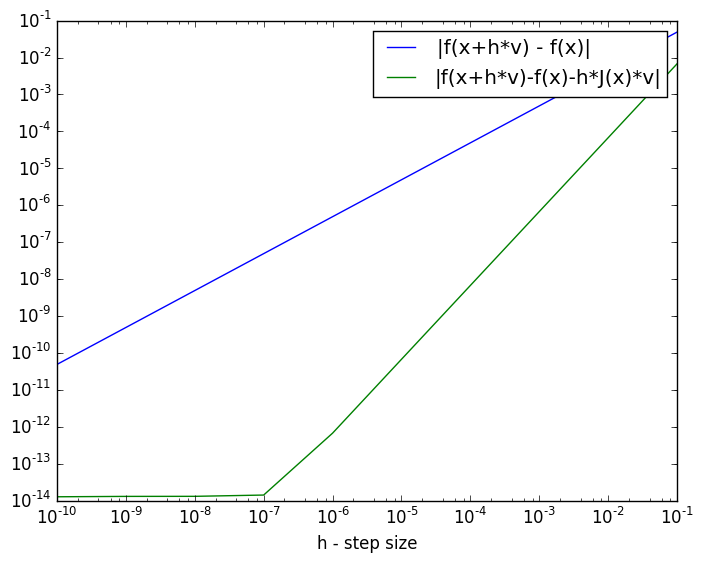

1.000e-10	4.898e-11	1.273e-14	1.000e+00	1.025e-02	    1


Test Passed
  Expression: isOK

In [8]:
isOK, his = checkDerivative(vec(k0),pFor,out=true)

h = logspace(-1,-10,10)
loglog(h,his[:,1])
loglog(h,his[:,2])
legend(("|f(x+h*v) - f(x)|","|f(x+h*v)-f(x)-h*J(x)*v|"))
xlabel("h - step size")

@test isOK

To ensure that `getSensTMatVec` is correct, we perform an adjoint test. For more details, type

```
?adjointTest
```

In [9]:
isAdjoint, = adjointTest(vec(k0),pFor,out=false)
@test isAdjoint

Test Passed
  Expression: isAdjoint